# TASK 1: Image reading and displaying

Image reading is a core functionality of any image processing algorithm and often available in the form of a function ‘imread()’. In this task you need to write your own ‘imread()’ function which can read .pgm images (pgm test dataset is given with this assignment). Once you read your image(s), you need display them with existing library call.

In [ ]:
%%capture
import matplotlib.pyplot as plt
import numpy as np
import os

import pywt
import pywt.data
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis

from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
def show_image_greyscale(image_matrix):
    """
    show_image_greyscale
    shows image in greyscale

    Input: matrix of image pixels
    Output: shows image
    """
    plt.imshow(image_matrix, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.margins(x=0)
    plt.show()

def read_pgm(im):
    """
    read_pgm reads pgm file and return the matrix store image data
    input: pgm file
    output: image matrix
    """
    with open(im, 'rb') as f:
        metadata = f.readline().decode("utf-8").rstrip('\n').split(" ")
        if len(metadata) == 1: # Read for more metadata in other line
            # Format
            format = metadata[0]
            
            # Check comment
            next_line = f.readline().decode("utf-8").rstrip('\n')
            while next_line.startswith('#'):
                next_line = f.readline().decode("utf-8").rstrip('\n')
            
            # Check Dimension
            shape = next_line.split(" ")
            num_rows = int(shape[1])
            num_columns = int(shape[0])

            # Get maximum grey level specify in the image
            max_grey_level = int(f.readline().decode("utf-8").rstrip('\n'))
        else: 
            format, num_columns, num_rows, max_grey_level = metadata[0], int(metadata[1]), int(metadata[2]), int(metadata[3])
        
        # Read pixel data
        pixel_data = f.read()
        if format == 'P2':
            # Decode byte to string to get the raster
            decoded_string = pixel_data.decode("utf-8")
            pgm_info = [int(data.strip("\n")) for data in decoded_string.split(" ") if data.strip("\n")]

            # Convert the list to a NumPy array and reshape
            pic = np.array(pgm_info, dtype=int).reshape(num_rows, num_columns) 
        
        elif format == 'P5':
            # Convert binary data to ASCII
            pixels = [byte for byte in pixel_data]
            pic = np.array(pixels, dtype=int).reshape(num_rows, num_columns)
        
        else:
            raise("Unknown format")

    # Create an image with that grayscale value
    ## TODO: Check why I need to normalize data in order to show
    # Normalize to the range [0, 1]
    grayscale_value = pic / max_grey_level  
    image_matrix = np.full((num_rows, num_columns), grayscale_value)

    return image_matrix

### Test read image

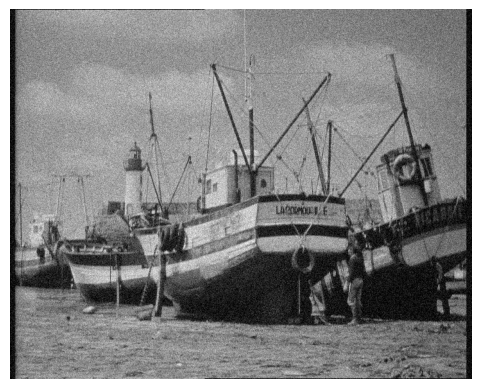

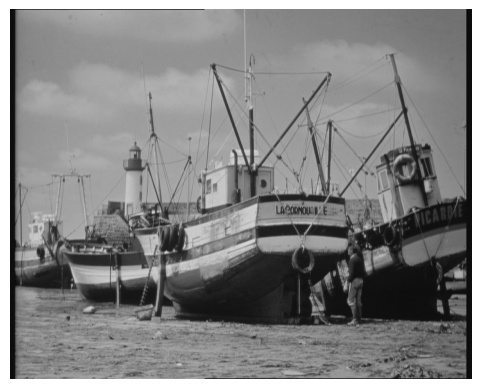

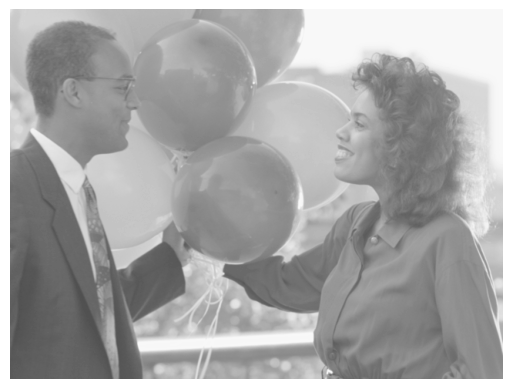

In [97]:
pgm_p5_oneline = "./Noisy/noisy_1/boats.pgm"
pgm_p5 = "./Dataset/boats.pgm"
pgm_p2 = "example.ascii.pgm"

show_image_greyscale(read_pgm(pgm_p5_oneline))
show_image_greyscale(read_pgm(pgm_p5))
show_image_greyscale(read_pgm(pgm_p2))

# TASK 2: Wavelet Decomposition
Transform spatial image to frequency domain using wavelet transformation on Haar Coefficient

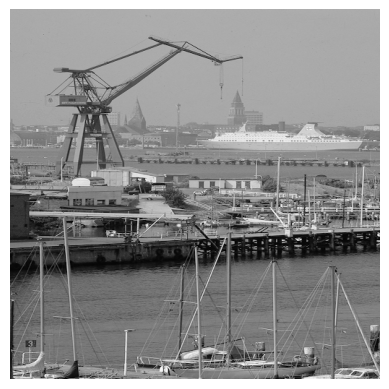

In [129]:
# Load image
im = convert_pgm_to_matrix("./Dataset/kiel.pgm")
show_image_greyscale(im)

In [ ]:
# Image Utility function
def show_images_4_grids(LL, LH, HL, HH, level):
    titles = ['Approximation', ' Horizontal detail', 'Vertical detail', 'Diagonal detail']
    fig = plt.figure(figsize=(8, 8))
    for i, a in enumerate([LL, LH, HL, HH]):
        ax = fig.add_subplot(2, 2, i + 1)
        ax.imshow(a, cmap=plt.cm.gray)
        ax.set_title(titles[i], fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig.tight_layout()
    fig.text(0.37, 1, f"Wavelet transformation Level {level}")
    plt.show()

## Forward and Inverse Wavelet Transform

In [239]:
def convolve_by_column(m, filter):
    num_row, num_col = m.shape
    result = np.zeros((num_row - 1, num_col))
    for r in range (num_row):
        for c in range (num_col):
            window = m[r:r+2, c]
            if window.shape[0] != 2:
                break

            result[r, c] = np.dot(filter, window)
    
    return result

def convolve_by_row(m, filter):
    num_row, num_col = m.shape
    result = np.zeros((num_row, num_col - 1))
    for r in range (num_row):
        for c in range (num_col):
            window = m[r, c:c+2]
            if window.shape[0] != 2:
                break

            result[r, c] = np.dot(filter, window)
    
    return result


def upsample_rows(matrix):
    """
    Upsample a 2D array along rows by inserting zeros between rows.
    """
    rows, cols = matrix.shape
    upsampled = np.zeros((2 * rows, cols))
    upsampled[::2, :] = matrix 

    return upsampled


def upsample_cols(matrix):
    """
    Upsample a 2D array along columns by inserting zeros between columns.
    """
    rows, cols = matrix.shape
    upsampled = np.zeros((rows, 2 * cols))
    upsampled[:, ::2] = matrix

    return upsampled

def downsample_cols(im):
    return im[:, ::2]

def downsample_rows(im):
    return im[::2, :]

## TODO: Write this function by myself
def symmetric_pad(image):
    # Calculate padding needed
    pad_width = 1
    
    # Symmetric padding on both sides
    padded_image = np.pad(image, 
                           ((pad_width//2, pad_width - pad_width//2), 
                            (pad_width//2, pad_width - pad_width//2)), 
                           mode='symmetric')
    return padded_image

def add_frequency(a, b):
    if a.shape == b.shape:
        return a + b
    
    diff_in_rows = a.shape[0] - b.shape[0]
    if diff_in_rows > 0:
        a = a[:-diff_in_rows, :]
    elif diff_in_rows < 0:
        b = b[:diff_in_rows, :]

    diff_in_cols = a.shape[1] - b.shape[1]
    if diff_in_cols > 0:
        a = a[:, :-diff_in_cols]
    elif diff_in_cols < 0:
        b = b[:, :diff_in_cols]
    
    return a+b

In [133]:
def forward_wavelet_transform(im):
    low_pass_filter = np.array([1, 1]) / np.sqrt(2)
    high_pass_filter = np.array([-1, 1]) / np.sqrt(2)

    L = downsample_cols(convolve_by_row(symmetric_pad(im), low_pass_filter))
    H = downsample_cols(convolve_by_row(symmetric_pad(im), high_pass_filter))

    LL = downsample_rows(convolve_by_column(L, low_pass_filter))
    LH = downsample_rows(convolve_by_column(L, high_pass_filter))
    HL = downsample_rows(convolve_by_column(H, low_pass_filter))
    HH = downsample_rows(convolve_by_column(H, high_pass_filter))

    return LL, LH, HL, HH

def inverse_wavelet_transform(LL, LH, HL, HH):
    low_pass_filter = np.array([1, 1]) / np.sqrt(2)
    high_pass_filter = np.array([1, -1]) / np.sqrt(2)

    reconstructed_L = add_frequency(convolve_by_column(upsample_rows(LH), high_pass_filter), convolve_by_column(upsample_rows(LL), low_pass_filter))
    reconstructed_H = convolve_by_column(upsample_rows(HH), high_pass_filter) + convolve_by_column(upsample_rows(HL), low_pass_filter)

    reconstructed_image = convolve_by_row(upsample_cols(symmetric_pad(reconstructed_L)), low_pass_filter) + convolve_by_row(upsample_cols(symmetric_pad(reconstructed_H)), high_pass_filter)

    # Crop to match the original size
    rows, cols = LL.shape[0] * 2, LL.shape[1] * 2
    return reconstructed_image[:rows, :cols]

In [164]:
def forward_wavelet_transform_with_level(image, level, show_image):
    result = []
    for l in range(1, level+1):
        LL, LH, HL, HH = forward_wavelet_transform(image)
        image = LL
        if show_image:
            show_images_4_grids(LL, LH, HL, HH, l)
        
        result.append(
            {
                "LL": LL, 
                "LH": LH, 
                "HL": HL, 
                "HH": HH
            }
        )
    
    return result

def inverse_wavelet_transform_many_levels(res):
    level = len(res)
    reconstructed_im = None
    
    for l in range(level - 1, -1, -1):
        LL, LH, HL, HH = res[l]["LL"], res[l]["LH"], res[l]["HL"], res[l]["HH"]
        if not reconstructed_im is None:
            LL = reconstructed_im
        
        reconstructed_im = inverse_wavelet_transform(LL, LH, HL, HH)

    return reconstructed_im
        

## Calculate MSE

In [103]:
def calculate_mse(original_image, reconstructed_image):
    num_rows, num_cols = original_image.shape
    reconstructed_image = reconstructed_image[:num_rows, :num_cols]

    return mean_squared_error(original_image, reconstructed_image)

## Test Wavelet forward transform 3 level

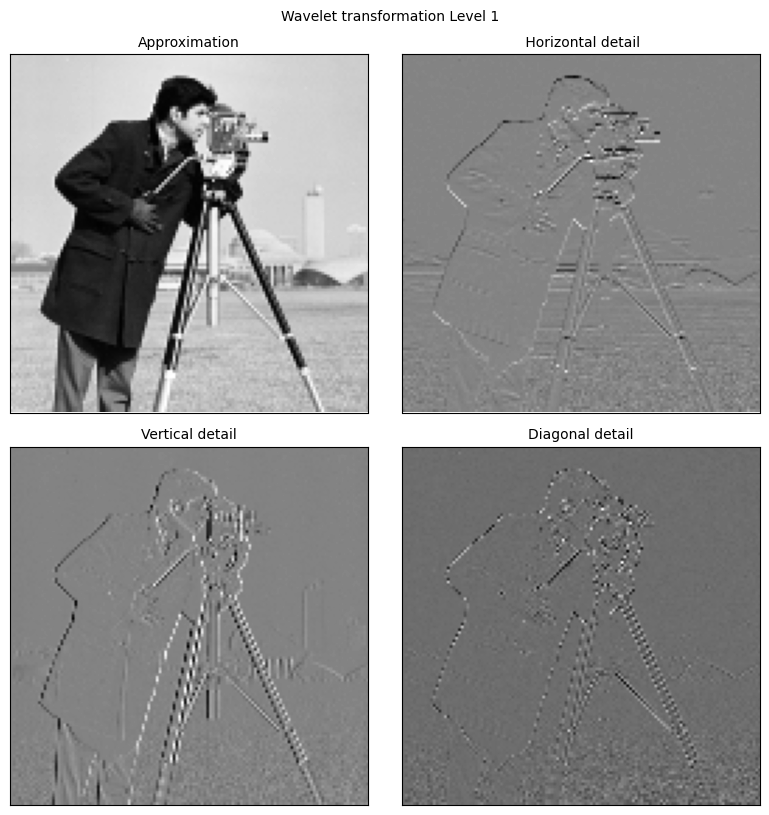

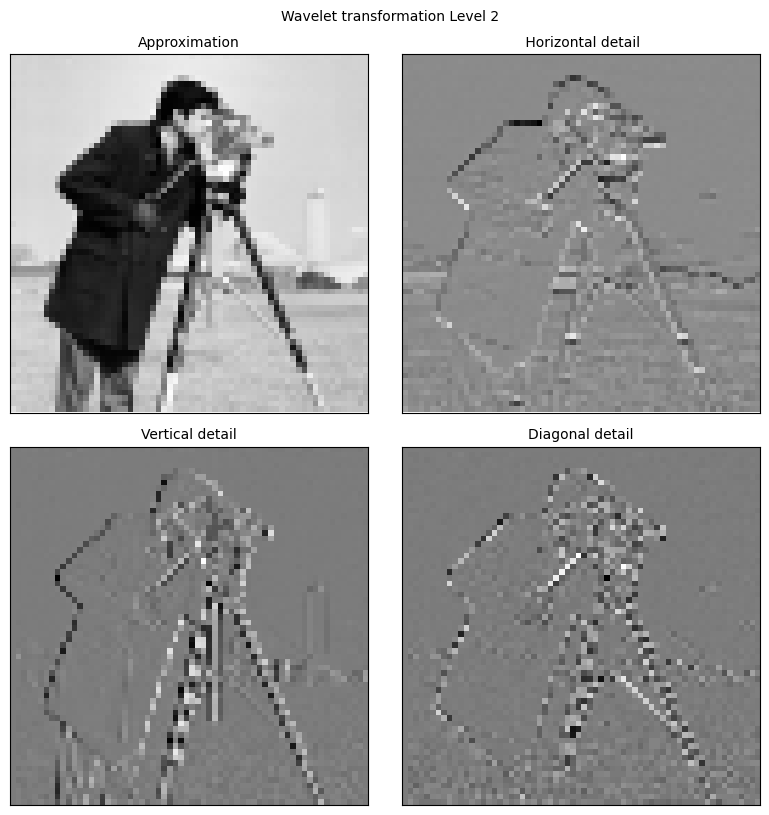

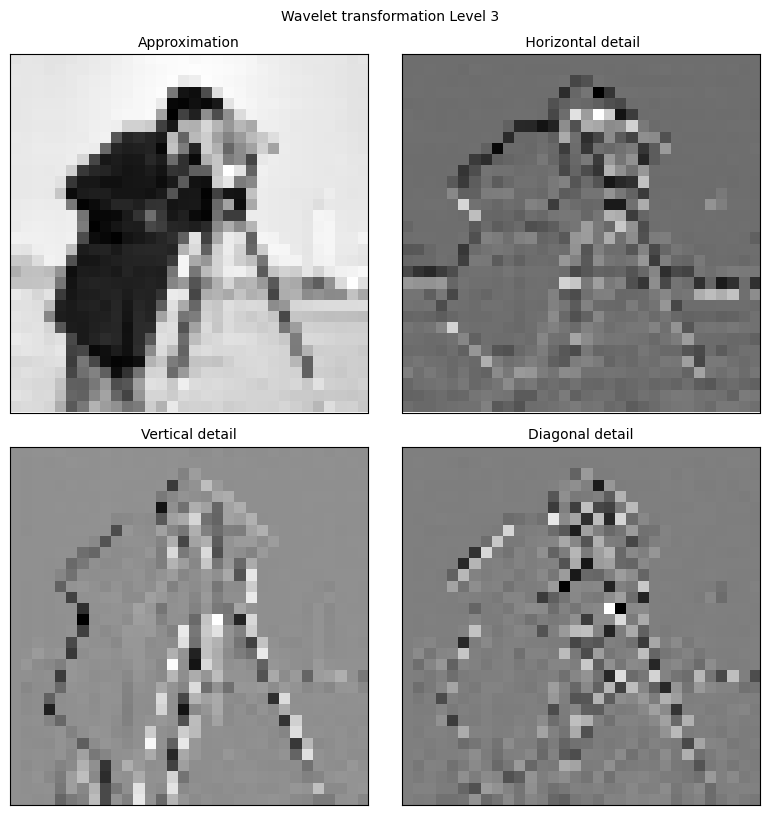

In [148]:
brain_image = convert_pgm_to_matrix("./Dataset/cameraman.pgm")

level = 3
show_result = True
res = forward_wavelet_transform_with_level(brain_image, level, show_result)

## Test inverse transform

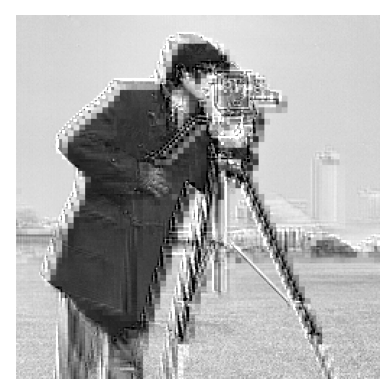

In [149]:
reconstructed_image = inverse_wavelet_transform_many_levels(res)
show_image_greyscale(reconstructed_image)

## Test calculate MSE

In [147]:
# Run all image

dataset_directory = './Dataset'
for filename in os.listdir(dataset_directory):
    if filename.endswith(".pgm"):
        file_with_directory = dataset_directory + "/" + filename
        print(file_with_directory)
        im = convert_pgm_to_matrix(file_with_directory)

        res = forward_wavelet_transform_with_level(im, 3, False)
        reconstructed_image = inverse_wavelet_transform_many_levels(res)
        mse = calculate_mse(im, reconstructed_image)

        print(f"MSE = {mse}")

./Dataset/man.pgm
MSE = 0.04590746575710809
./Dataset/lungs.pgm
MSE = 0.128407551899788
./Dataset/clown.pgm
MSE = 0.046492682089946655
./Dataset/clock.pgm
MSE = 0.35729079664876334
./Dataset/kiel.pgm
MSE = 0.1206686284367002
./Dataset/zelda2.pgm
MSE = 0.02143322034918531
./Dataset/dogbone.pgm
MSE = 0.017513668547100132
./Dataset/truck.pgm
MSE = 0.04354245181818816
./Dataset/couple.pgm
MSE = 0.07750769242650023
./Dataset/mandrill.pgm
MSE = 0.17859121917349105
./Dataset/boats.pgm
MSE = 0.037957778301933594
./Dataset/cameraman.pgm
MSE = 0.4527197409354453
./Dataset/crowd.pgm
MSE = 0.06743604469739292
./Dataset/girlface.pgm
MSE = 0.05375860307364212
./Dataset/houses.pgm
MSE = 0.11176275755615685
./Dataset/Brain1.pgm
MSE = 0.05161049609615963
./Dataset/barbara.pgm
MSE = 0.11731924542093743
./Dataset/lighthouse.pgm
MSE = 0.11602799848610024
./Dataset/bridge.pgm
MSE = 0.1194802381624764


# Task 3: Denoise

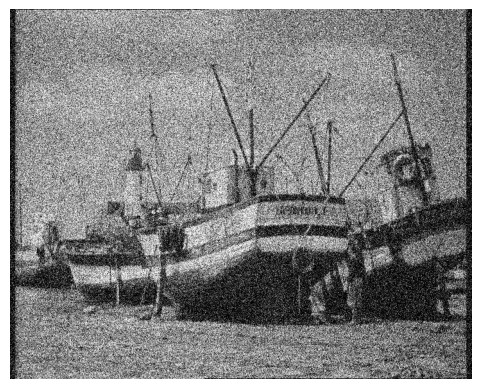

In [111]:
file = './Noisy/noisy_3/boats.pgm'
im = read_pgm(file)

# res = forward_wavelet_transform_with_level(im, 3,)
# reconstructed_image = inverse_wavelet_transform_many_levels_2(res)
show_image_greyscale(im)

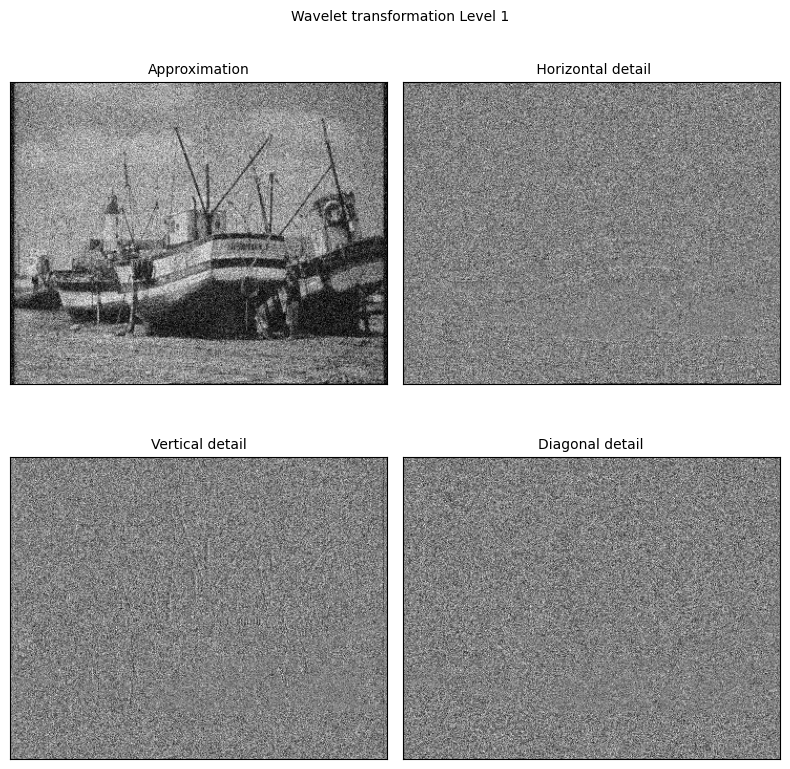

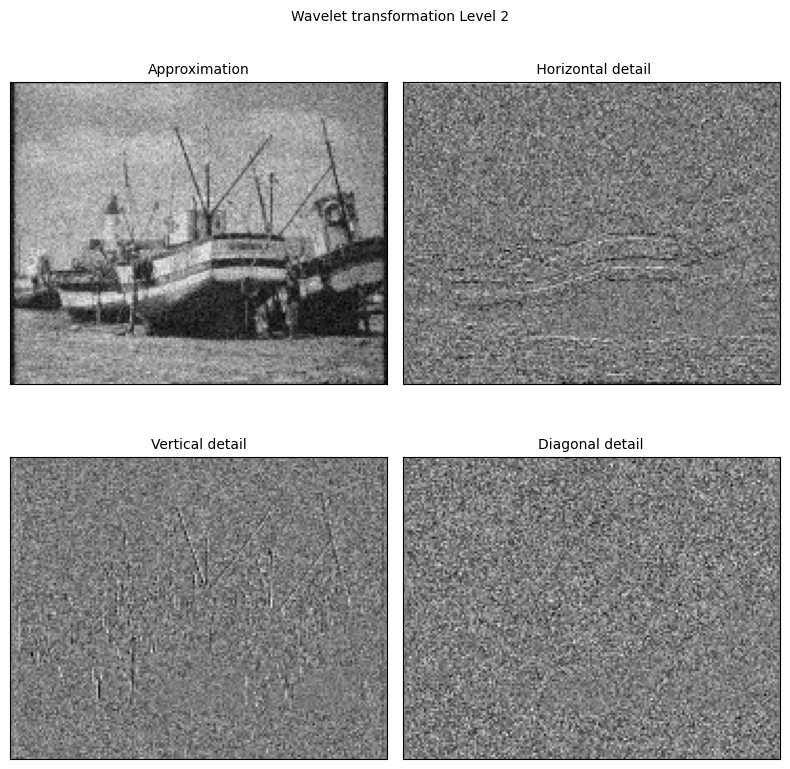

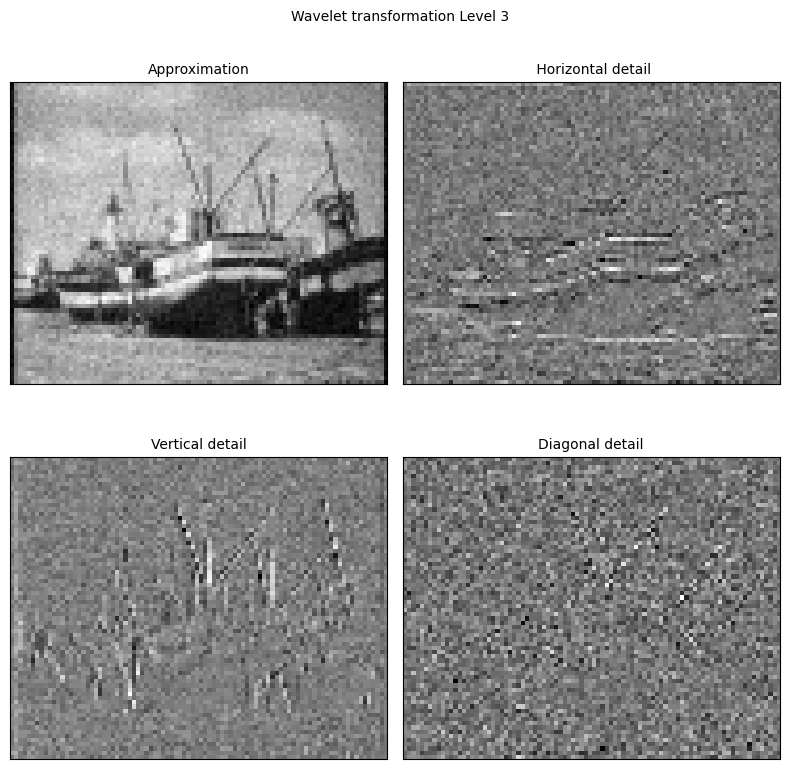

In [117]:
res = forward_wavelet_transform_with_level(im, 3, True)

In [122]:
import pywt
brain_image = convert_pgm_to_matrix("./Dataset/Brain1.pgm")

coeffs2 = pywt.wavedec2(brain_image, 'haar', level=3)
LL = coeffs2

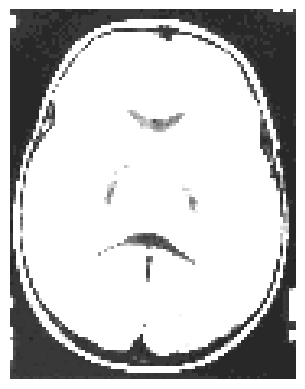

In [127]:
show_image_greyscale(LL[0])

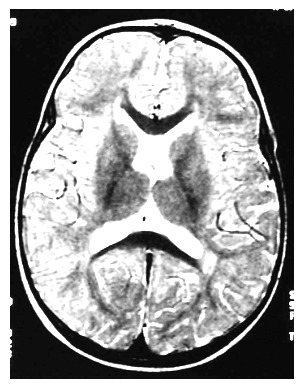

In [119]:
show_image_greyscale(LL)

# Improve wavelet transform

In [339]:
def downsample_cols(im):
    print("---Downsample col---")
    print(im[:, ::2])
    print("======")
    return im[:, ::2]

def downsample_rows(im):
    print("---Downsample row---")
    print(im[::2, :])
    print("======")
    return im[::2, :]

def upsample_rows(matrix):
    """
    Upsample a 2D array along rows by inserting zeros first.
    """
    rows, cols = matrix.shape
    upsampled = np.zeros(((2 * rows) + 1, cols))
    upsampled[1::2, :] = matrix  # Put matrix values in odd indices (1,3,5...)
    return upsampled


def upsample_cols(matrix):
    """
    Upsample a 2D array along columns by inserting zeros between columns.
    """
    rows, cols = matrix.shape
    upsampled = np.zeros((rows, 2 * cols))
    upsampled[:, 1::2] = matrix

    return upsampled

def convolve_by_column(m, filter):
    num_row, num_col = m.shape
    result = np.zeros((num_row - 1, num_col))
    for r in range (num_row):
        for c in range (num_col):
            window = m[r:r+2, c]
            if window.shape[0] != 2:
                break

            result[r, c] = np.dot(filter, window)

    return result

def convolve_by_row(m, filter):
    num_row, num_col = m.shape
    result = np.zeros((num_row, num_col - 1))
    for r in range (num_row):
        for c in range (num_col):
            window = m[r, c:c+2]
            if window.shape[0] != 2:
                break

            result[r, c] = np.dot(filter, window)
    return result


In [351]:
def forward_wavelet_transform(im):
    low_pass_filter = np.array([1, 1]) / np.sqrt(2)
    high_pass_filter = np.array([1, -1]) / np.sqrt(2)

    print("System pad =", symmetric_pad(im))
    
    print("-----L-------")
    L = downsample_cols(convolve_by_row(symmetric_pad(im), low_pass_filter))

    print("-----H-------")
    H = downsample_cols(convolve_by_row(symmetric_pad(im), high_pass_filter))

    print("-----LL-------")
    LL = downsample_rows(convolve_by_column(L, low_pass_filter))
    print("-----LH-------")
    LH = downsample_rows(convolve_by_column(L, high_pass_filter))
    print("-----HL-------")
    HL = downsample_rows(convolve_by_column(H, low_pass_filter))
    print("-----HH-------")
    HH = downsample_rows(convolve_by_column(H, high_pass_filter))

    return LL, LH, HL, HH

def inverse_wavelet_transform(LL, LH, HL, HH):
    low_pass_filter = np.array([1, 1]) / np.sqrt(2)
    high_pass_filter = np.array([-1, 1]) / np.sqrt(2)

    print("Original LL")
    print(LL)

    print("----- Reverse LL ------")
    reverse_LL = convolve_by_column(upsample_rows(LL), low_pass_filter)
    print(reverse_LL)

    print("----- Reverse LH ------")
    reverse_LH = convolve_by_column(upsample_rows(LH), high_pass_filter)
    print(reverse_LH)


    print("----- Reverse L -------")
    reconstructed_L = add_frequency(reverse_LH, reverse_LL)
    print(reconstructed_L)

    print("----- Reverse HL ------")
    reverse_HL = convolve_by_column(upsample_rows(HL), low_pass_filter)
    print(reverse_HL)
 
    print("----- Reverse HH ------")
    reverse_HH = convolve_by_column(upsample_rows(HH), high_pass_filter)
    print(reverse_HH)
    

    print("----- Reverse H -------")
    reconstructed_H = add_frequency(reverse_HH, reverse_HL)
    print(reconstructed_H)

    print("reconstructed_image")
    reconstructed_image = convolve_by_row(upsample_cols(symmetric_pad(reconstructed_L)), low_pass_filter) + convolve_by_row(upsample_cols(symmetric_pad(reconstructed_H)), high_pass_filter)
    print(reconstructed_image)

    # reconstructed_L = add_frequency(convolve_by_column(upsample_rows(LH), high_pass_filter), convolve_by_column(upsample_rows(LL), low_pass_filter))
    # reconstructed_H = convolve_by_column(upsample_rows(HH), high_pass_filter) + convolve_by_column(upsample_rows(HL), low_pass_filter)

    # reconstructed_image = convolve_by_row(upsample_cols(symmetric_pad(reconstructed_L)), low_pass_filter) + convolve_by_row(upsample_cols(symmetric_pad(reconstructed_H)), high_pass_filter)

    # Find original size
    LL_rows = LL.shape[0]
    LL_cols = LL.shape[1]

    if LL_rows % 2 == 0:
        original_rows = LL_rows*2
    else:
        original_rows = ((LL_rows - 1)*2) + 1
    
    if LL_cols % 2 == 0:
        original_cols = LL_cols*2
    else:
        original_cols = ((LL_cols - 1)*2) + 1

    print(f"Original rows = {original_rows}")
    print(f"Original cols = {original_cols}")

    # rows, cols = LL.shape[0] * 2, LL.shape[1] * 2
    return reconstructed_image[:original_rows, :original_cols]

In [356]:
starter = np.arange(0,20).reshape(5, 4)
starter

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15],
       [16, 17, 18, 19]])

In [357]:
a, b,c,d = forward_wavelet_transform(starter)
print(a)
print(b)
print(c)
print(d)

System pad = [[ 0  1  2  3  3]
 [ 4  5  6  7  7]
 [ 8  9 10 11 11]
 [12 13 14 15 15]
 [16 17 18 19 19]
 [16 17 18 19 19]]
-----L-------
---Downsample col---
[[ 0.70710678  3.53553391]
 [ 6.36396103  9.19238816]
 [12.02081528 14.8492424 ]
 [17.67766953 20.50609665]
 [23.33452378 26.1629509 ]
 [23.33452378 26.1629509 ]]
-----H-------
---Downsample col---
[[-0.70710678 -0.70710678]
 [-0.70710678 -0.70710678]
 [-0.70710678 -0.70710678]
 [-0.70710678 -0.70710678]
 [-0.70710678 -0.70710678]
 [-0.70710678 -0.70710678]]
-----LL-------
---Downsample row---
[[ 5.  9.]
 [21. 25.]
 [33. 37.]]
-----LH-------
---Downsample row---
[[-4. -4.]
 [-4. -4.]
 [ 0.  0.]]
-----HL-------
---Downsample row---
[[-1. -1.]
 [-1. -1.]
 [-1. -1.]]
-----HH-------
---Downsample row---
[[ 0.00000000e+00 -2.77555756e-16]
 [ 0.00000000e+00  6.10622664e-16]
 [ 0.00000000e+00  0.00000000e+00]]
[[ 5.  9.]
 [21. 25.]
 [33. 37.]]
[[-4. -4.]
 [-4. -4.]
 [ 0.  0.]]
[[-1. -1.]
 [-1. -1.]
 [-1. -1.]]
[[ 0.00000000e+00 -2.7755575

In [358]:
final = inverse_wavelet_transform(a,b,c,d)
final

Original LL
[[ 5.  9.]
 [21. 25.]
 [33. 37.]]
----- Reverse LL ------
[[ 3.53553391  6.36396103]
 [ 3.53553391  6.36396103]
 [14.8492424  17.67766953]
 [14.8492424  17.67766953]
 [23.33452378 26.1629509 ]
 [23.33452378 26.1629509 ]]
----- Reverse LH ------
[[-2.82842712 -2.82842712]
 [ 2.82842712  2.82842712]
 [-2.82842712 -2.82842712]
 [ 2.82842712  2.82842712]
 [ 0.          0.        ]
 [ 0.          0.        ]]
----- Reverse L -------
[[ 0.70710678  3.53553391]
 [ 6.36396103  9.19238816]
 [12.02081528 14.8492424 ]
 [17.67766953 20.50609665]
 [23.33452378 26.1629509 ]
 [23.33452378 26.1629509 ]]
----- Reverse HL ------
[[-0.70710678 -0.70710678]
 [-0.70710678 -0.70710678]
 [-0.70710678 -0.70710678]
 [-0.70710678 -0.70710678]
 [-0.70710678 -0.70710678]
 [-0.70710678 -0.70710678]]
----- Reverse HH ------
[[ 0.00000000e+00 -1.96261557e-16]
 [ 0.00000000e+00  1.96261557e-16]
 [ 0.00000000e+00  4.31775426e-16]
 [ 0.00000000e+00 -4.31775426e-16]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00

array([[5.55111512e-17, 1.00000000e+00, 2.00000000e+00, 3.00000000e+00],
       [4.00000000e+00, 5.00000000e+00, 6.00000000e+00, 7.00000000e+00],
       [8.00000000e+00, 9.00000000e+00, 1.00000000e+01, 1.10000000e+01],
       [1.20000000e+01, 1.30000000e+01, 1.40000000e+01, 1.50000000e+01],
       [1.60000000e+01, 1.70000000e+01, 1.80000000e+01, 1.90000000e+01]])

In [176]:
calculate_mse(starter, final)

np.float64(33.99999999999996)

In [263]:
coeffs = pywt.dwt2(starter, 'haar')
cA, (cH, cV, cD) = coeffs
print(cA)
print(cH)
print(cV)
print(cD)

[[ 5.  9.]
 [21. 25.]]
[[-4. -4.]
 [-4. -4.]]
[[-1. -1.]
 [-1. -1.]]
[[ 1.70656864e-16 -5.87450838e-16]
 [ 3.00727582e-16  4.05861454e-17]]


In [264]:
pywt.idwt2(coeffs, 'haar')

array([[ 0.,  1.,  2.,  3.],
       [ 4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11.],
       [12., 13., 14., 15.]])

In [228]:
def upsample_rows(m):
    """
    Upsample rows by inserting zero rows between existing rows.
    """
    num_row, num_col = m.shape
    result = np.zeros((num_row * 2, num_col))
    result[::2, :] = m  # Insert original rows at even indices
    return result


def upsample_cols(m):
    """
    Upsample columns by inserting zero columns between existing columns.
    """
    num_row, num_col = m.shape
    result = np.zeros((num_row, num_col * 2))
    result[:, ::2] = m  # Insert original columns at even indices
    return result


In [232]:


def convolve_by_column(m, filter):
    num_row, num_col = m.shape
    filter_len = len(filter)

    # The result matrix should have a reduced number of rows
    result = np.zeros((num_row - filter_len + 1, num_col))

    for r in range(num_row - filter_len + 1):  # Avoid out-of-bounds
        for c in range(num_col):
            # Apply the filter to the column window
            window = m[r:r+filter_len, c]
            result[r, c] = np.dot(filter, window)

    return result

def convolve_by_row(m, filter):
    num_row, num_col = m.shape
    filter_len = len(filter)

    # The result matrix should have a reduced number of columns
    result = np.zeros((num_row, num_col - filter_len + 1))

    for r in range(num_row):
        for c in range(num_col - filter_len + 1):  # Avoid out-of-bounds
            # Apply the filter to the row window
            window = m[r, c:c+filter_len]
            result[r, c] = np.dot(filter, window)

    return result






In [230]:
final = inverse_wavelet_transform(a,b,c,d)
final

array([[ 7.,  8.,  9., 10., 11.],
       [13., 14., 15., 16., 17.],
       [19., 20., 21., 22., 23.]])